In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import gc
import time
import datetime
import copy
import random
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

In [2]:
torch.__version__

'1.3.1'

In [3]:
torch.cuda.empty_cache()

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed = 0
seed_everything(seed=seed)

---
# Metadata

In [5]:
data_dir = '..\\input'

metadata_path = glob.glob(os.path.join(data_dir, '*.json'))

In [6]:
# load metadata
metadata = pd.DataFrame()
for path in metadata_path:
    metadata = pd.concat([metadata, pd.read_json(path).T], axis=0)
    
metadata.reset_index(inplace=True)
metadata = metadata.rename(columns={'index': 'mov'})

In [7]:
metadata.head()

,mov,label,split,original
0,owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
1,vpmyeepbep.mp4,REAL,train,NaN
2,fzvpbrzssi.mp4,REAL,train,NaN
3,htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
4,fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


In [8]:
# Label
metadata['label'].value_counts()

FAKE    5593
REAL     643
Name: label, dtype: int64

In [9]:
# 1Real movie 1 fake
mov_path = []
real_list = metadata[metadata['label'] == 'REAL']['mov'].tolist()
for path in real_list:
    mov_path.append(metadata[metadata['original'] == path]['mov'].tolist()[0])
mov_path.extend(real_list)
mov_path = [os.path.join(data_dir, path) for path in mov_path]

---
# Movie to Image

In [10]:
def get_img_from_mov(video_file, show_img=False):
    # https://note.nkmk.me/python-opencv-videocapture-file-camera/
    cap = cv2.VideoCapture(video_file)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    image_list = []
    for i in range(frames):
        _, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image)
    cap.release()

    if show_img:
        fig, ax = plt.subplots(1,1, figsize=(15, 15))
        ax.imshow(image[0])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
        plt.grid(False)
        
    return image_list

---
# Face Detection

In [11]:
def detect_face(img):
    # Add Dataset "Haarcascades"
    face_cascade = cv2.CascadeClassifier('..\\haarcascade\\haarcascade_frontalface_alt.xml')
    face_crops = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
    
    if len(face_crops) == 0:
        return []
    
    crop_imgs = []
    for i in range(len(face_crops)):
        x = face_crops[i][0]
        y = face_crops[i][1]
        w = face_crops[i][2]
        h = face_crops[i][3]
        #x,y,w,h=ratio*x,ratio*y,ratio*w,ratio*h
        crop_imgs.append(img[y:y+h, x:x+w])
    return crop_imgs

---
# Dataset

In [12]:
class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image

# Data Augumentation
class ImageTransform():
    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                Resize(resize),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                Resize(resize),
                transforms.ToTensor(),
            ])
        }
        self.size = resize
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)
    
    
class DeepfakeDataset_idx0(Dataset):
    def __init__(self, file_list, metadata, transform=None, phase='train'):
        self.file_list = file_list
        self.metadata = metadata
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        mov_path = self.file_list[idx]
        
        # Label
        label = self.metadata[self.metadata['mov'] == mov_path.split('\\')[-1]]['label'].values
        
        if label == 'FAKE':
            label = 1.0
        else:
            label = 0.0
        
        # Movie to Image
        try:
            image = get_img_from_mov(mov_path, show_img=False)[0] # Only First Frame Face
            # FaceCrop
            image = detect_face(image)[0]
            # Transform
            image = self.transform(image, self.phase)
        except:
            image = torch.ones((3, self.transform.size, self.transform.size), dtype=torch.float)
            label = 1.0
        
        return image, label, mov_path

---
# Model

In [13]:
# Resnet
use_pretrained = True
net = models.resnet152(pretrained=use_pretrained)
# Change Last Layer
# Output Features 1000 → 1
net.fc = nn.Linear(in_features=2048, out_features=1)
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# Fine Tuning
# params_to_update_1 = []
# params_to_update_2 = []
# params_to_update_3 = []

# update_param_name_1 = ["layer2", "layer3"]
# update_param_name_2 = ["layer4"]
# update_param_name_3 = ["fc.weight", "fc.bias"]

# for name, param in net.named_parameters():
#     if update_param_name_1[0] in name:
#         param.requires_grad= True
#         params_to_update_1.append(param)
        
#     elif update_param_name_1[1] in name:
#         param.requires_grad= True
#         params_to_update_1.append(param)
            
#     elif update_param_name_2[0] in name:
#             param.requires_grad= True
#             params_to_update_2.append(param)
#     elif name in update_param_name_3:
#             param.requires_grad= True
#             params_to_update_3.append(param)
#     else:
#         param.requires_grad = False
        
# optimizer = optim.SGD([
#     {'params': params_to_update_1, 'lr': 1e-4},
#     {'params': params_to_update_2, 'lr': 5e-4},
#     {'params': params_to_update_3, 'lr': 1e-3},
# ], momentum=0.9)

In [15]:
# Transfer Training
# Specify The Layers for updating
params_to_update = []
update_params_name = ['fc.weight', 'fc.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False

optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
print('Done')

Done


---
# Train

In [16]:
# Set RawData  #########################################################
# Divide Train, Valid Dataset
train_mov_path, val_mov_path = train_test_split(mov_path, test_size=0.1)

# Config  #########################################################
size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 4
criterion = nn.BCEWithLogitsLoss()

# Dataset  #########################################################
train_dataset = DeepfakeDataset_idx0(train_mov_path, metadata, ImageTransform(size), 'train')
val_dataset = DeepfakeDataset_idx0(val_mov_path, metadata, ImageTransform(size), 'val')

# Dataloader  #########################################################
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}


In [17]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels, _ in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs.view(-1), labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    preds = torch.sigmoid(outputs.view(-1))
                    # replace binary
                    preds[preds > 0.5] = 1
                    preds[preds <= 0.5] = 0
                    epoch_corrects += torch.sum(preds == labels).item()
                    
                del inputs, labels
                gc.collect()
                torch.cuda.empty_cache()
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [18]:
# Train
num_epoch = 6
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/6
--------------------


d:\python\kaggle\deepfa~1\env\venv~1\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



train Loss: 0.5225 Acc: 0.7381



val Loss: 0.3758 Acc: 0.7752
Epoch 2/6
--------------------



train Loss: 0.5016 Acc: 0.7295



val Loss: 0.4032 Acc: 0.7287
Epoch 3/6
--------------------



train Loss: 0.5018 Acc: 0.7329



val Loss: 0.3836 Acc: 0.8062
Epoch 4/6
--------------------



train Loss: 0.4542 Acc: 0.7511



val Loss: 0.3437 Acc: 0.8295
Epoch 5/6
--------------------



train Loss: 0.4473 Acc: 0.7684



val Loss: 0.3751 Acc: 0.7752
Epoch 6/6
--------------------



train Loss: 0.4644 Acc: 0.7623



val Loss: 0.3685 Acc: 0.7984
Training complete in 423m 59s
Best val Acc: 0.829457


In [19]:
torch.cuda.empty_cache()

In [20]:
# Save Model
date = datetime.datetime.now().strftime('%Y%m%d')
torch.save(net.state_dict(), "../model/resnet152_ep{}_{}.pth".format(num_epoch, date))

---
# Prediction

In [21]:
# Prediction
label_list = []
pred_list = []
path_list = []

with torch.no_grad():
    for img, label, mov_path in tqdm(val_dataset):
        img = img.unsqueeze(0)
        img = img.to(device)

        net.eval()

        outputs = net(img)
        preds = torch.sigmoid(outputs).item()
        
        label_list.append(label)
        pred_list.append(preds)
        path_list.append(mov_path)
    
res = pd.DataFrame({
    'label': label_list,
    'pred': pred_list,
    'path': path_list
})

res.to_csv('../output/submission_resnet50.csv', index=False)

d:\python\kaggle\deepfa~1\env\venv~1\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [22]:
res

,label,pred,path
0,0.0,0.384878,..\input\bvpeerislp.mp4
1,0.0,0.177727,..\input\dhjnjkzuhq.mp4
2,1.0,0.766422,..\input\twovjcbdmv.mp4
3,1.0,0.592220,..\input\oqejtxqvhp.mp4
4,0.0,0.178051,..\input\hmywawbhvc.mp4
...,...,...,...
124,1.0,0.940575,..\input\clkgvdosxe.mp4
125,1.0,0.940575,..\input\libmahdeva.mp4
126,1.0,0.627413,..\input\maczkptqhf.mp4
127,0.0,0.243412,..\input\qabreprhxg.mp4


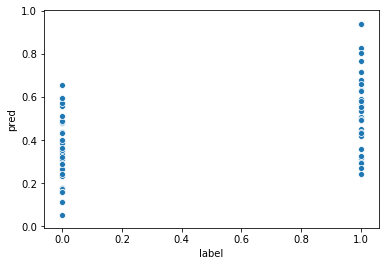

In [23]:
import seaborn as sns
sns.scatterplot(x='label', y='pred', data=res)

In [24]:
# val Loss: 0.1966 Acc: 0.9225
# Training complete in 720m 3s
# Best val Acc: 0.930233